# Simulation Study 9: Comprehensive Scenarios and Sample Size Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from scipy import linalg, stats
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import warnings
import time
from itertools import product
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
print("\n Libraries loaded - Ready for comprehensive simulation!")
print(f"   Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")

🚀 Device: cuda
   GPU: NVIDIA GeForce RTX 4070 Laptop GPU
   Memory: 8.6 GB

✅ Libraries loaded - Ready for comprehensive simulation!
   Date: 2026-01-23 17:21


## 1. Geography and Data Generation Functions

In [ ]:
def generate_districts(n_districts=80, district_size='medium', spatial_extent=10.0, seed=None):
    """
    Generate district geography with varying district sizes.
    
    Parameters:
    -----------
    district_size : str
        'small' (5-10 precincts), 'medium' (10-15), 'large' (20-30)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Determine number of precincts based on district size
    size_map = {
        'small': (5, 10),
        'medium': (10, 15),
        'large': (20, 30)
    }
    min_prec, max_prec = size_map[district_size]
    precincts_per_district = np.random.randint(min_prec, max_prec + 1)
    n_precincts = n_districts * precincts_per_district
    
    # Precinct locations
    locations = np.random.uniform(0, spatial_extent, (n_precincts, 2))
    
    # Cluster into districts
    kmeans = KMeans(n_clusters=n_districts, random_state=seed, n_init=10)
    assignments = kmeans.fit_predict(locations)
    
    # District centroids
    centroids = np.zeros((n_districts, 2))
    for d in range(n_districts):
        mask = (assignments == d)
        if mask.sum() > 0:
            centroids[d] = locations[mask].mean(axis=0)
    
    return {
        'precinct_locations': locations,
        'precinct_assignments': assignments,
        'centroids': centroids,
        'n_districts': n_districts,
        'n_precincts': n_precincts,
        'district_size': district_size,
        'avg_precincts_per_district': n_precincts / n_districts
    }

def simulate_redistricting(old_data, intensity='moderate', seed=None):
    """Simulate redistricting with varying intensity."""
    if seed is not None:
        np.random.seed(seed)
    
    intensity_map = {'minor': 0.3, 'moderate': 0.8, 'major': 1.5}
    noise_scale = intensity_map[intensity]
    
    old_locs = old_data['precinct_locations']
    noise = np.random.normal(0, noise_scale, old_locs.shape)
    new_locs = np.clip(old_locs + noise, 0, old_locs.max())
    
    # Recluster
    kmeans = KMeans(n_clusters=old_data['n_districts'], random_state=seed+1000, n_init=10)
    new_assignments = kmeans.fit_predict(new_locs)
    
    # New centroids
    centroids = np.zeros((old_data['n_districts'], 2))
    for d in range(old_data['n_districts']):
        mask = (new_assignments == d)
        if mask.sum() > 0:
            centroids[d] = new_locs[mask].mean(axis=0)
    
    # Overlap calculation
    overlap_pct = (old_data['precinct_assignments'] == new_assignments).mean()
    
    # Overlap matrix
    overlap = np.zeros((old_data['n_districts'], old_data['n_districts']))
    for new_d in range(old_data['n_districts']):
        mask_new = (new_assignments == new_d)
        if mask_new.sum() == 0:
            continue
        for old_d in range(old_data['n_districts']):
            shared = np.logical_and(mask_new, old_data['precinct_assignments'] == old_d).sum()
            overlap[new_d, old_d] = shared / mask_new.sum() if mask_new.sum() > 0 else 0
    
    return {
        'precinct_locations': new_locs,
        'precinct_assignments': new_assignments,
        'centroids': centroids,
        'n_districts': old_data['n_districts'],
        'n_precincts': old_data['n_precincts'],
        'overlap_matrix': overlap,
        'overlap_pct': overlap_pct,
        'intensity': intensity,
        'district_size': old_data['district_size']
    }

def create_adjacency(centroids, k_neighbors=None):
    """Create k-nearest neighbor adjacency (adaptive k)."""
    n = len(centroids)
    
    # Adaptive k based on number of districts
    if k_neighbors is None:
        if n <= 40:
            k_neighbors = max(4, int(n * 0.15))
        elif n <= 100:
            k_neighbors = max(6, int(n * 0.10))
        else:
            k_neighbors = max(8, int(n * 0.08))
    
    dist_mat = distance_matrix(centroids, centroids)
    adjacency = np.zeros((n, n))
    
    for i in range(n):
        k_actual = min(k_neighbors, n - 1)
        nearest = np.argsort(dist_mat[i, :])[1:k_actual+1]
        adjacency[i, nearest] = 1
        adjacency[nearest, i] = 1
    
    np.fill_diagonal(adjacency, 1)
    return adjacency

print(" Geography functions defined")

✅ Geography functions defined


## 2. Proper CAR Model Implementation

In [ ]:
def generate_features(precinct_locations, precinct_assignments, n_districts, n_features=5, seed=None):
    """Generate spatially correlated features."""
    if seed is not None:
        np.random.seed(seed)
    
    n_precincts = len(precinct_locations)
    
    # Generate spatially smooth precinct features
    X_precinct = np.random.randn(n_precincts, n_features)
    
    # Add spatial correlation
    dist_mat = distance_matrix(precinct_locations, precinct_locations)
    W_spatial = np.exp(-dist_mat / dist_mat.std())
    
    for f in range(n_features):
        for _ in range(3):
            X_precinct[:, f] = 0.7 * X_precinct[:, f] + 0.3 * (W_spatial @ X_precinct[:, f]) / W_spatial.sum(axis=1)
    
    # Aggregate to districts
    X_district = np.zeros((n_districts, n_features))
    for d in range(n_districts):
        mask = (precinct_assignments == d)
        if mask.sum() > 0:
            X_district[d] = X_precinct[mask].mean(axis=0)
    
    # Standardize
    X_district = (X_district - X_district.mean(axis=0)) / (X_district.std(axis=0) + 1e-8)
    
    return X_district

def generate_CAR_outcomes(X_features, adjacency, rho=0.7, beta=None, sigma=0.08, seed=None):
    """
    Generate outcomes using PROPER CAR model.
    
    CAR Model: y = (I - ρW)^(-1) · (μ + ε)
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_districts = len(X_features)
    
    # Weak beta coefficients
    if beta is None:
        beta = np.array([0.10, 0.08, -0.05, 0.03, -0.07])[:X_features.shape[1]]
    
    # Feature effects
    mu = X_features @ beta
    
    # Row-normalized adjacency WITHOUT self-loops
    W = adjacency.copy().astype(float)
    np.fill_diagonal(W, 0)
    
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1
    W = W / row_sums[:, np.newaxis]
    
    # Validate rho
    eigenvalues = np.linalg.eigvals(W)
    lambda_max = np.max(np.abs(eigenvalues))
    rho_max = 0.99 / lambda_max
    
    if rho >= rho_max:
        rho = 0.95 * rho_max
    
    # Independent noise
    epsilon = np.random.normal(0, sigma, n_districts)
    
    # CAR MODEL: y = (I - ρW)^(-1) · (μ + ε)
    I = np.eye(n_districts)
    A = I - rho * W
    y = np.linalg.solve(A, mu + epsilon)
    
    # Scale to [0, 1] vote share range
    y_scaled = (y - y.min()) / (y.max() - y.min())
    y_scaled = 0.35 + (y_scaled - 0.5) * 0.5
    y_scaled = np.clip(y_scaled, 0.05, 0.95)
    
    return y_scaled, beta

def calculate_morans_i(y, adjacency):
    """Calculate Moran's I for spatial autocorrelation."""
    n = len(y)
    W = adjacency.copy()
    np.fill_diagonal(W, 0)
    W_sum = W.sum()
    
    if W_sum == 0:
        return 0.0
    
    y_mean = y.mean()
    y_dev = y - y_mean
    
    numerator = np.sum(W * np.outer(y_dev, y_dev))
    denominator = np.sum(y_dev ** 2)
    
    if denominator == 0:
        return 0.0
    
    morans_i = (n / W_sum) * (numerator / denominator)
    return morans_i

print(" CAR generation functions defined")

✅ CAR generation functions defined


## 3. GNN Models (GPU-Optimized)

In [ ]:
class SimpleGCN(nn.Module):
    """Graph Convolutional Network."""
    def __init__(self, n_features, hidden_dims=[32, 16, 8], dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(n_features, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.fc = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        return torch.sigmoid(self.fc(x)).squeeze()

class GraphAttentionNet(nn.Module):
    """Graph Attention Network."""
    def __init__(self, n_features, hidden_dims=[32, 16, 8], heads=4, dropout=0.1):
        super().__init__()
        self.conv1 = GATConv(n_features, hidden_dims[0], heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dims[0] * heads, hidden_dims[1], heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_dims[1] * heads, hidden_dims[2], heads=1, dropout=dropout)
        self.fc = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv3(x, edge_index))
        return torch.sigmoid(self.fc(x)).squeeze()

class HybridGNN(nn.Module):
    """Hybrid: GCN + Dense branches."""
    def __init__(self, n_features, hidden_dims=[32, 16, 8], dropout=0.1):
        super().__init__()
        # GCN branch
        self.conv1 = GCNConv(n_features, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        
        # Dense branch
        self.fc1 = nn.Linear(n_features, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        
        # Combined
        self.fc3 = nn.Linear(hidden_dims[1] * 2, hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        # GCN path
        x_gcn = F.relu(self.conv1(x, edge_index, edge_weight))
        x_gcn = self.dropout(x_gcn)
        x_gcn = F.relu(self.conv2(x_gcn, edge_index, edge_weight))
        
        # Dense path
        x_dense = F.relu(self.fc1(x))
        x_dense = self.dropout(x_dense)
        x_dense = F.relu(self.fc2(x_dense))
        
        # Combine
        x_combined = torch.cat([x_gcn, x_dense], dim=1)
        x = F.relu(self.fc3(x_combined))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x)).squeeze()

class DenseNN(nn.Module):
    """Baseline Dense Neural Network."""
    def __init__(self, n_features, hidden_dims=[64, 32, 16], dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(n_features, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x)).squeeze()

print(" GNN models defined (GCN, GAT, Hybrid, Dense)")

✅ GNN models defined (GCN, GAT, Hybrid, Dense)


## 4. Graph Construction and Transfer Learning

In [ ]:
def construct_geo_graph(centroids, k=None):
    """Geographic proximity graph."""
    n = len(centroids)
    
    # Adaptive k
    if k is None:
        if n <= 40:
            k = max(4, int(n * 0.15))
        elif n <= 100:
            k = max(6, int(n * 0.10))
        else:
            k = max(8, int(n * 0.08))
    
    dist_mat = distance_matrix(centroids, centroids)
    A = np.zeros((n, n))
    
    for i in range(n):
        k_actual = min(k, n - 1)
        nearest = np.argsort(dist_mat[i, :])[1:k_actual+1]
        for j in nearest:
            weight = 1.0 / (1.0 + dist_mat[i, j])
            A[i, j] = weight
            A[j, i] = weight
    
    np.fill_diagonal(A, 1.0)
    row_sums = A.sum(axis=1, keepdims=True)
    return A / np.maximum(row_sums, 1)

def construct_feat_graph(X, k=None):
    """Feature similarity graph."""
    n = len(X)
    
    # Adaptive k
    if k is None:
        k = max(4, min(8, int(n * 0.1)))
    
    dist = distance_matrix(X, X)
    A = np.exp(-dist**2 / (2 * 1.0**2))
    
    for i in range(n):
        k_actual = min(k, n - 1)
        threshold_idx = np.argsort(A[i, :])[-(k_actual+1)]
        threshold = A[i, threshold_idx]
        A[i, A[i, :] < threshold] = 0
    
    A = (A + A.T) / 2
    np.fill_diagonal(A, 1.0)
    row_sums = A.sum(axis=1, keepdims=True)
    return A / np.maximum(row_sums, 1)

def construct_transfer_graph(overlap_matrix, threshold=0.01):
    """Transfer learning graph from overlaps."""
    A = overlap_matrix.copy()
    A[A < threshold] = 0
    A = (A + A.T) / 2
    np.fill_diagonal(A, 1.0)
    row_sums = A.sum(axis=1, keepdims=True)
    return A / np.maximum(row_sums, 1)

def construct_combined_graph(A_geo, A_feat, A_transfer, alpha=0.5, beta=0.2, gamma=0.3):
    """Combine graph modalities."""
    total = alpha + beta + gamma
    alpha, beta, gamma = alpha/total, beta/total, gamma/total
    A = alpha * A_geo + beta * A_feat + gamma * A_transfer
    A = np.maximum(A, 0)
    row_sums = A.sum(axis=1, keepdims=True)
    return A / np.maximum(row_sums, 1)

def to_edge_index(adjacency, threshold=0.01):
    """Convert adjacency to PyG edge_index."""
    rows, cols = np.where(adjacency >= threshold)
    edge_index = torch.tensor(np.stack([rows, cols]), dtype=torch.long)
    edge_weight = torch.tensor(adjacency[rows, cols], dtype=torch.float)
    return edge_index, edge_weight

print(" Graph construction functions defined")

✅ Graph construction functions defined


## 5. Training and Evaluation

In [ ]:
def train_gnn(model, data_old, data_new, epochs=150, lr=0.005, device='cpu'):
    """Train GNN on old districts, predict on new."""
    model = model.to(device)
    data_old = data_old.to(device)
    data_new = data_new.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        out = model(data_old.x, data_old.edge_index, data_old.edge_weight)
        loss = criterion(out[data_old.train_mask], data_old.y[data_old.train_mask])
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        pred_new = model(data_new.x, data_new.edge_index, data_new.edge_weight)
    
    return pred_new.cpu().numpy(), data_new.y.cpu().numpy()

def train_dense(X_train, y_train, X_test, epochs=120, lr=0.005, device='cpu'):
    """Train baseline Dense NN."""
    model = DenseNN(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    criterion = nn.MSELoss()
    
    X_train_t = torch.tensor(X_train, dtype=torch.float).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float).to(device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_t)
        loss = criterion(pred, y_train_t)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        pred_test = model(X_test_t).cpu().numpy()
    
    return pred_test

def evaluate(y_true, y_pred):
    """Calculate metrics."""
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'r2': r2_score(y_true, y_pred)
    }

print(" Training functions defined")

✅ Training functions defined


## 6. Comprehensive Simulation Study

**Experimental Design Summary**:
- **5 sample sizes**: 30, 50, 80, 120, 200 districts
- **5 spatial ρ values**: 0.3, 0.5, 0.65, 0.8, 0.9
- **3 k-neighbors values**: 4, 6, 8 (graph connectivity)
- **3 district sizes**: small, medium, large
- **3 redistricting intensities**: minor, moderate, major
- **10 replications** per scenario
- **Total**: 5 × 5 × 3 × 3 × 3 × 10 = **6,750 simulations**

In [ ]:
def run_single_simulation(n_districts, rho, k_neighbors, district_size, intensity, seed, device='cpu', verbose=False):
    """
    Run one simulation scenario.
    
    Parameters:
    -----------
    k_neighbors : int
        Number of nearest neighbors for graph construction
    verbose : bool
        If True, print detailed scenario information
    
    Returns metrics for all 4 models.
    """
    try:
        if verbose:
            print(f"\n{'='*70}")
            print(f"Scenario: n={n_districts}, ρ={rho}, k={k_neighbors}, size={district_size}, intensity={intensity}")
            print(f"{'='*70}")
        
        # Generate old districts
        old_data = generate_districts(n_districts=n_districts, 
                                       district_size=district_size,
                                       seed=seed)
        
        X_old = generate_features(old_data['precinct_locations'],
                                  old_data['precinct_assignments'],
                                  old_data['n_districts'],
                                  seed=seed)
        
        adj_old = create_adjacency(old_data['centroids'], k_neighbors=k_neighbors)
        y_old, beta = generate_CAR_outcomes(X_old, adj_old, rho=rho, seed=seed)
        
        # Calculate Moran's I
        morans_i = calculate_morans_i(y_old, adj_old)
        
        if verbose:
            print(f"  Old districts: {old_data['n_districts']}, Precincts: {old_data['n_precincts']}")
            print(f"  Moran's I: {morans_i:.4f}")
        
        # Generate new districts (redistricting)
        new_data = simulate_redistricting(old_data, intensity=intensity, seed=seed+5000)
        
        X_new = generate_features(new_data['precinct_locations'],
                                  new_data['precinct_assignments'],
                                  new_data['n_districts'],
                                  seed=seed+5000)
        
        adj_new = create_adjacency(new_data['centroids'], k_neighbors=k_neighbors)
        y_new, _ = generate_CAR_outcomes(X_new, adj_new, rho=rho, beta=beta, seed=seed+5000)
        
        if verbose:
            print(f"  Overlap: {new_data['overlap_pct']*100:.1f}%")
        
        # Construct graphs
        A_geo_old = construct_geo_graph(old_data['centroids'], k=k_neighbors)
        A_feat_old = construct_feat_graph(X_old, k=k_neighbors)
        A_geo_new = construct_geo_graph(new_data['centroids'], k=k_neighbors)
        A_feat_new = construct_feat_graph(X_new, k=k_neighbors)
        A_transfer = construct_transfer_graph(new_data['overlap_matrix'])
        
        # Combined graphs
        A_old_combined = construct_combined_graph(A_geo_old, A_feat_old, 
                                                  np.eye(n_districts), 0.6, 0.4, 0.0)
        A_new_combined = construct_combined_graph(A_geo_new, A_feat_new, 
                                                  A_transfer, 0.4, 0.3, 0.3)
        
        # Convert to PyG format
        edge_index_old, edge_weight_old = to_edge_index(A_old_combined)
        edge_index_new, edge_weight_new = to_edge_index(A_new_combined)
        
        # Train mask (80% of old districts)
        n_train = int(0.8 * n_districts)
        train_mask = torch.zeros(n_districts, dtype=torch.bool)
        train_mask[:n_train] = True
        
        # PyG Data objects
        data_old = Data(
            x=torch.tensor(X_old, dtype=torch.float),
            y=torch.tensor(y_old, dtype=torch.float),
            edge_index=edge_index_old,
            edge_weight=edge_weight_old,
            train_mask=train_mask
        )
        
        data_new = Data(
            x=torch.tensor(X_new, dtype=torch.float),
            y=torch.tensor(y_new, dtype=torch.float),
            edge_index=edge_index_new,
            edge_weight=edge_weight_new
        )
        
        # Train models
        results = {}
        
        # 1. GCN
        if verbose:
            print(f"  Training GCN...", end='', flush=True)
        model_gcn = SimpleGCN(X_old.shape[1])
        pred_gcn, true_gcn = train_gnn(model_gcn, data_old, data_new, 
                                       epochs=150, device=device)
        results['GCN'] = evaluate(true_gcn, pred_gcn)
        if verbose:
            print(f" MAE={results['GCN']['mae']:.4f}, R²={results['GCN']['r2']:.4f}")
        
        # 2. GAT
        if verbose:
            print(f"  Training GAT...", end='', flush=True)
        model_gat = GraphAttentionNet(X_old.shape[1])
        pred_gat, true_gat = train_gnn(model_gat, data_old, data_new, 
                                       epochs=150, device=device)
        results['GAT'] = evaluate(true_gat, pred_gat)
        if verbose:
            print(f" MAE={results['GAT']['mae']:.4f}, R²={results['GAT']['r2']:.4f}")
        
        # 3. Hybrid
        if verbose:
            print(f"  Training Hybrid...", end='', flush=True)
        model_hybrid = HybridGNN(X_old.shape[1])
        pred_hybrid, true_hybrid = train_gnn(model_hybrid, data_old, data_new, 
                                             epochs=150, device=device)
        results['Hybrid'] = evaluate(true_hybrid, pred_hybrid)
        if verbose:
            print(f" MAE={results['Hybrid']['mae']:.4f}, R²={results['Hybrid']['r2']:.4f}")
        
        # 4. Dense NN
        if verbose:
            print(f"  Training Dense...", end='', flush=True)
        pred_dense = train_dense(X_old[:n_train], y_old[:n_train], X_new, 
                                epochs=120, device=device)
        results['Dense'] = evaluate(y_new, pred_dense)
        if verbose:
            print(f" MAE={results['Dense']['mae']:.4f}, R²={results['Dense']['r2']:.4f}")
        
        # Package results
        scenario_info = {
            'n_districts': n_districts,
            'rho': rho,
            'k_neighbors': k_neighbors,
            'district_size': district_size,
            'intensity': intensity,
            'seed': seed,
            'morans_i': morans_i,
            'overlap_pct': new_data['overlap_pct'],
            'avg_precincts_per_district': old_data['avg_precincts_per_district']
        }
        
        if verbose:
            best_model = min(results.keys(), key=lambda m: results[m]['mae'])
            print(f"   Best model: {best_model} (MAE={results[best_model]['mae']:.4f})")
        
        return {**scenario_info, **{f'{model}_{metric}': results[model][metric]
                                    for model in results
                                    for metric in results[model]}}
    
    except Exception as e:
        print(f"Error in simulation (n={n_districts}, rho={rho}, size={district_size}): {e}")
        return None

print(" Simulation runner defined")

✅ Simulation runner defined


## 7. Execute Comprehensive Simulation Study

In [ ]:
# ===== SELECT YOUR OPTION HERE =====
OPTION = "B"  # Change to "A", "B", or "C"

# Define base experimental factors
n_districts_levels_full = [30, 50, 80, 120, 200]
rho_levels_full = [0.3, 0.5, 0.65, 0.8, 0.9]
district_size_levels_full = ['small', 'medium', 'large']
intensity_levels_full = ['minor', 'moderate', 'major']

# Configure based on selected option
if OPTION == "A":
    # ULTRA-FAST: Reduced factors, fewer reps
    n_districts_levels = [30, 80, 200]  # 3 levels instead of 5
    rho_levels = [0.3, 0.65, 0.9]  # 3 levels instead of 5
    k_neighbors_levels = [6]  # Single k value
    district_size_levels = ['medium']  # Single size
    intensity_levels = ['moderate']  # Single intensity
    n_replications = 5  # Fewer reps
    print(" OPTION A: ULTRA-FAST MODE")
    print("   3×3×1×1×1 = 9 scenarios × 5 reps = 45 simulations per model combo")
    
elif OPTION == "B":
    # FAST: Full coverage but single k
    n_districts_levels = n_districts_levels_full
    rho_levels = rho_levels_full
    k_neighbors_levels = [6]  # Single k value (medium connectivity)
    district_size_levels = district_size_levels_full
    intensity_levels = intensity_levels_full
    n_replications = 10
    print(" OPTION B: FAST MODE (RECOMMENDED)")
    print("   5×5×1×3×3 = 225 scenarios × 10 reps = 2,250 simulations")
    
else:  # OPTION == "C"
    # COMPLETE: Full factorial design
    n_districts_levels = n_districts_levels_full
    rho_levels = rho_levels_full
    k_neighbors_levels = [4, 6, 8]  # All k values
    district_size_levels = district_size_levels_full
    intensity_levels = intensity_levels_full
    n_replications = 10
    print(" OPTION C: COMPLETE MODE")
    print("   5×5×3×3×3 = 675 scenarios × 10 reps = 6,750 simulations")

# Create all combinations
scenarios = list(product(n_districts_levels, rho_levels, k_neighbors_levels,
                        district_size_levels, intensity_levels))

print("="*80)
print("COMPREHENSIVE SIMULATION STUDY")
print("="*80)
print(f"Total scenarios: {len(scenarios)} (unique factor combinations)")
print(f"Replications per scenario: {n_replications}")
print(f"Total simulations: {len(scenarios) * n_replications}")
print(f"Device: {device}")
print("="*80)
print("\nExperimental Factors:")
print(f"  • Number of districts: {n_districts_levels}")
print(f"  • Spatial ρ: {rho_levels}")
print(f"  • k-neighbors (graph connectivity): {k_neighbors_levels}")
print(f"  • District size: {district_size_levels}")
print(f"  • Redistricting intensity: {intensity_levels}")
print(f"  • Replications per scenario: {n_replications}")
print("\n k-neighbors: Controls graph connectivity (how many neighbors each district connects to)")
print("   Higher k → denser graphs → more information flow in GNN")

# Estimate time
total_sims = len(scenarios) * n_replications
if device.type == 'cuda':
    est_mins_low = total_sims * 0.02  # ~1.2 sec per sim on GPU
    est_mins_high = total_sims * 0.04  # ~2.4 sec per sim on GPU
    print(f"\n⏱  Estimated time on GPU: {est_mins_low:.0f}-{est_mins_high:.0f} minutes")
else:
    est_mins_low = total_sims * 0.15  # ~9 sec per sim on CPU
    est_mins_high = total_sims * 0.25  # ~15 sec per sim on CPU
    print(f"\n⏱  Estimated time on CPU: {est_mins_low:.0f}-{est_mins_high:.0f} minutes")

print("="*80)

COMPREHENSIVE SIMULATION STUDY
Total scenarios: 675 (unique factor combinations)
Replications per scenario: 10
Total simulations: 6750
Device: cuda

Experimental Factors:
  • Number of districts: [30, 50, 80, 120, 200]
  • Spatial ρ: [0.3, 0.5, 0.65, 0.8, 0.9]
  • k-neighbors (graph connectivity): [4, 6, 8]
  • District size: ['small', 'medium', 'large']
  • Redistricting intensity: ['minor', 'moderate', 'major']

💡 k-neighbors: Controls graph connectivity (how many neighbors each district connects to)
   Higher k → denser graphs → more information flow in GNN


In [ ]:
# Run simulations with progress tracking
all_results = []
start_time = time.time()

total_sims = len(scenarios) * n_replications
completed = 0

print(f"\n Starting simulation study at {pd.Timestamp.now().strftime('%H:%M:%S')}\n")

for i, (n_dist, rho, k_neigh, dist_size, intensity) in enumerate(scenarios):
    scenario_results = []
    
    # Print scenario header
    if i % 5 == 0 or i < 3:  # Print more details for first few scenarios
        print(f"\n{'─'*80}")
        print(f"Scenario {i+1}/{len(scenarios)}: n={n_dist}, ρ={rho}, k={k_neigh}, "
              f"size={dist_size}, intensity={intensity}")
        print(f"{'─'*80}")
    
    # Run replications
    for rep in range(n_replications):
        seed = i * 1000 + rep * 10
        
        # Show details for first replication of each scenario
        verbose = (rep == 0 and (i < 3 or i % 10 == 0))
        
        result = run_single_simulation(
            n_districts=n_dist,
            rho=rho,
            k_neighbors=k_neigh,
            district_size=dist_size,
            intensity=intensity,
            seed=seed,
            device=device,
            verbose=verbose
        )
        
        if result is not None:
            scenario_results.append(result)
        
        completed += 1
        
        # Progress update every 20 simulations
        if completed % 20 == 0:
            elapsed = time.time() - start_time
            rate = completed / elapsed
            remaining = (total_sims - completed) / rate
            print(f"\n Progress: {completed}/{total_sims} ({100*completed/total_sims:.1f}%) | "
                  f"Elapsed: {elapsed/60:.1f}m | ETA: {remaining/60:.1f}m | "
                  f"Rate: {rate:.1f} sims/sec")
    
    # Show scenario summary
    if len(scenario_results) > 0:
        avg_mae = np.mean([r['GCN_mae'] for r in scenario_results])
        avg_r2 = np.mean([r['GCN_r2'] for r in scenario_results])
        if i < 3 or i % 10 == 0:
            print(f"  ✓ Scenario complete: {len(scenario_results)} reps | "
                  f"GCN avg: MAE={avg_mae:.4f}, R²={avg_r2:.4f}")
    
    all_results.extend(scenario_results)
    
    # Save intermediate results every 25 scenarios
    if (i + 1) % 25 == 0:
        df_temp = pd.DataFrame(all_results)
        df_temp.to_csv('simulation_results_comprehensive_temp.csv', index=False)
        print(f"\n Checkpoint saved: {len(all_results)} results so far")

# Convert to DataFrame
df_results = pd.DataFrame(all_results)

# Save final results
df_results.to_csv('simulation_results_comprehensive_final.csv', index=False)

elapsed_total = time.time() - start_time
print("\n" + "="*80)
print(f" SIMULATION COMPLETE!")
print(f"   Total time: {elapsed_total/60:.1f} minutes")
print(f"   Successful simulations: {len(df_results)}/{total_sims}")
print(f"   Results saved to: simulation_results_comprehensive_final.csv")
print("="*80)


🚀 Starting simulation study at 17:22:01


────────────────────────────────────────────────────────────────────────────────
Scenario 1/675: n=30, ρ=0.3, k=4, size=small, intensity=minor
────────────────────────────────────────────────────────────────────────────────

Scenario: n=30, ρ=0.3, k=4, size=small, intensity=minor
  Old districts: 30, Precincts: 270
  Moran's I: 0.0284
  Overlap: 6.3%
  Training GCN... MAE=0.0756, R²=0.2849
  Training GAT... MAE=0.1112, R²=-0.3173
  Training Hybrid... MAE=0.0634, R²=0.5884
  Training Dense... MAE=0.0707, R²=0.5028
  ✅ Best model: Hybrid (MAE=0.0634)
  ✓ Scenario complete: 10 reps | GCN avg: MAE=0.0808, R²=0.1634

────────────────────────────────────────────────────────────────────────────────
Scenario 2/675: n=30, ρ=0.3, k=4, size=small, intensity=moderate
────────────────────────────────────────────────────────────────────────────────

Scenario: n=30, ρ=0.3, k=4, size=small, intensity=moderate
  Old districts: 30, Precincts: 240
  Moran's I: 0

## 8. Summary Statistics and Data Quality Checks

In [20]:
# Load results (in case we're restarting from saved file)
df_results = pd.read_csv('simulation_results_comprehensive_final.csv')

print("="*80)
print("DATA SUMMARY")
print("="*80)
print(f"\nTotal simulations: {len(df_results)}")
print(f"Unique scenarios: {df_results.groupby(['n_districts', 'rho', 'k_neighbors', 'district_size', 'intensity']).ngroups}")
print(f"\nColumns: {list(df_results.columns)}")

print("\n" + "-"*80)
print("FACTOR LEVELS CHECK:")
print("-"*80)
for col in ['n_districts', 'rho', 'k_neighbors', 'district_size', 'intensity']:
    print(f"{col}: {sorted(df_results[col].unique())}")

print("\n" + "-"*80)
print("DESCRIPTIVE STATISTICS:")
print("-"*80)

# Moran's I statistics
print("\nMoran's I by spatial ρ:")
morans_summary = df_results.groupby('rho')['morans_i'].agg(['mean', 'std', 'min', 'max'])
print(morans_summary.round(4))

# Overlap statistics
print("\nPrecinct overlap by redistricting intensity:")
overlap_summary = df_results.groupby('intensity')['overlap_pct'].agg(['mean', 'std', 'min', 'max'])
print(overlap_summary.round(4))

# Sample size statistics
print("\nDistrict counts:")
print(df_results.groupby('n_districts').size())

print("\n" + "="*80)

DATA SUMMARY

Total simulations: 6750
Unique scenarios: 675

Columns: ['n_districts', 'rho', 'k_neighbors', 'district_size', 'intensity', 'seed', 'morans_i', 'overlap_pct', 'avg_precincts_per_district', 'GCN_mae', 'GCN_rmse', 'GCN_r2', 'GAT_mae', 'GAT_rmse', 'GAT_r2', 'Hybrid_mae', 'Hybrid_rmse', 'Hybrid_r2', 'Dense_mae', 'Dense_rmse', 'Dense_r2']

--------------------------------------------------------------------------------
FACTOR LEVELS CHECK:
--------------------------------------------------------------------------------
n_districts: [30, 50, 80, 120, 200]
rho: [0.3, 0.5, 0.65, 0.8, 0.9]
k_neighbors: [4, 6, 8]
district_size: ['large', 'medium', 'small']
intensity: ['major', 'minor', 'moderate']

--------------------------------------------------------------------------------
DESCRIPTIVE STATISTICS:
--------------------------------------------------------------------------------

Moran's I by spatial ρ:
        mean     std     min     max
rho                                 
0.3

## 9. Analysis Tables for Manuscript

### Table 1: Effect of Sample Size on Model Performance

In [ ]:
# Table 1: Sample size effect (averaged across all other factors)
def create_sample_size_table(df):
    """Create table showing effect of number of districts."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for n_dist in sorted(df['n_districts'].unique()):
        df_subset = df[df['n_districts'] == n_dist]
        
        row = {'n_districts': n_dist, 'n_sims': len(df_subset)}
        
        for model in models:
            for metric in metrics:
                col_name = f'{model}_{metric}'
                mean_val = df_subset[col_name].mean()
                std_val = df_subset[col_name].std()
                row[f'{model}_{metric}_mean'] = mean_val
                row[f'{model}_{metric}_std'] = std_val
        
        results.append(row)
    
    return pd.DataFrame(results)

table_sample_size = create_sample_size_table(df_results)

print("="*80)
print("TABLE 1: Effect of Sample Size (Number of Districts)")
print("="*80)
print("\nMAE (Mean Absolute Error) - Lower is Better:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_sample_size.iterrows():
        mean = row[f'{model}_mae_mean']
        std = row[f'{model}_mae_std']
        print(f"  n={row['n_districts']:3d}: {mean:.4f} ± {std:.4f}")

print("\n" + "="*80)
print("\nRMSE (Root Mean Squared Error) - Lower is Better:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_sample_size.iterrows():
        mean = row[f'{model}_rmse_mean']
        std = row[f'{model}_rmse_std']
        print(f"  n={row['n_districts']:3d}: {mean:.4f} ± {std:.4f}")

print("\n" + "="*80)
print("\nR² Score - Higher is Better:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_sample_size.iterrows():
        mean = row[f'{model}_r2_mean']
        std = row[f'{model}_r2_std']
        print(f"  n={row['n_districts']:3d}: {mean:.4f} ± {std:.4f}")

# Save table
table_sample_size.to_csv('table_sample_size_effect.csv', index=False)
print("\n Table saved to: table_sample_size_effect.csv")

TABLE 1: Effect of Sample Size (Number of Districts)

MAE (Mean Absolute Error) - Lower is Better:
--------------------------------------------------------------------------------

GCN:


ValueError: Unknown format code 'd' for object of type 'float'

### Table 2: Effect of Spatial Autocorrelation (ρ)

In [ ]:
# Table 2: Spatial ρ effect
def create_rho_table(df):
    """Create table showing effect of spatial autocorrelation."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for rho in sorted(df['rho'].unique()):
        df_subset = df[df['rho'] == rho]
        
        row = {
            'rho': rho, 
            'n_sims': len(df_subset),
            'morans_i_mean': df_subset['morans_i'].mean(),
            'morans_i_std': df_subset['morans_i'].std()
        }
        
        for model in models:
            for metric in metrics:
                col_name = f'{model}_{metric}'
                row[f'{model}_{metric}_mean'] = df_subset[col_name].mean()
                row[f'{model}_{metric}_std'] = df_subset[col_name].std()
        
        results.append(row)
    
    return pd.DataFrame(results)

table_rho = create_rho_table(df_results)

print("="*80)
print("TABLE 2: Effect of Spatial Autocorrelation (ρ)")
print("="*80)

print("\nVerification: Moran's I by ρ (confirms CAR is working):")
print("-"*80)
for _, row in table_rho.iterrows():
    print(f"ρ={row['rho']:.2f}: Moran's I = {row['morans_i_mean']:.4f} ± {row['morans_i_std']:.4f}")

print("\n" + "-"*80)
print("\nMAE by Spatial ρ:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_rho.iterrows():
        mean = row[f'{model}_mae_mean']
        std = row[f'{model}_mae_std']
        print(f"  ρ={row['rho']:.2f}: {mean:.4f} ± {std:.4f}")

print("\n" + "-"*80)
print("\nR² by Spatial ρ:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_rho.iterrows():
        mean = row[f'{model}_r2_mean']
        std = row[f'{model}_r2_std']
        print(f"  ρ={row['rho']:.2f}: {mean:.4f} ± {std:.4f}")

# Save table
table_rho.to_csv('table_spatial_rho_effect.csv', index=False)
print("\n Table saved to: table_spatial_rho_effect.csv")

TABLE 2: Effect of Spatial Autocorrelation (ρ)

Verification: Moran's I by ρ (confirms CAR is working):
--------------------------------------------------------------------------------
ρ=0.30: Moran's I = 0.1666 ± 0.1134
ρ=0.50: Moran's I = 0.2857 ± 0.1386
ρ=0.65: Moran's I = 0.4033 ± 0.1541
ρ=0.80: Moran's I = 0.5522 ± 0.1692
ρ=0.90: Moran's I = 0.6836 ± 0.1733

--------------------------------------------------------------------------------

MAE by Spatial ρ:
--------------------------------------------------------------------------------

GCN:
  ρ=0.30: 0.0718 ± 0.0208
  ρ=0.50: 0.0677 ± 0.0199
  ρ=0.65: 0.0655 ± 0.0199
  ρ=0.80: 0.0667 ± 0.0213
  ρ=0.90: 0.0739 ± 0.0212

GAT:
  ρ=0.30: 0.0880 ± 0.0287
  ρ=0.50: 0.0862 ± 0.0276
  ρ=0.65: 0.0854 ± 0.0286
  ρ=0.80: 0.0877 ± 0.0299
  ρ=0.90: 0.0950 ± 0.0315

Hybrid:
  ρ=0.30: 0.0606 ± 0.0196
  ρ=0.50: 0.0611 ± 0.0190
  ρ=0.65: 0.0623 ± 0.0183
  ρ=0.80: 0.0687 ± 0.0203
  ρ=0.90: 0.0788 ± 0.0206

Dense:
  ρ=0.30: 0.0617 ± 0.0200
  ρ=0.50

### Table 3: Interaction - Sample Size × Spatial ρ

In [ ]:
# Table 3: Interaction between sample size and spatial rho
def create_interaction_table(df, metric='mae'):
    """Create table showing n_districts × ρ interaction."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    
    results = []
    
    for n_dist in sorted(df['n_districts'].unique()):
        for rho in sorted(df['rho'].unique()):
            df_subset = df[(df['n_districts'] == n_dist) & (df['rho'] == rho)]
            
            if len(df_subset) == 0:
                continue
            
            row = {
                'n_districts': n_dist,
                'rho': rho,
                'n_sims': len(df_subset),
                'morans_i': df_subset['morans_i'].mean()
            }
            
            for model in models:
                col_name = f'{model}_{metric}'
                row[f'{model}_mean'] = df_subset[col_name].mean()
                row[f'{model}_std'] = df_subset[col_name].std()
            
            results.append(row)
    
    return pd.DataFrame(results)

# Create interaction table for MAE
table_interaction_mae = create_interaction_table(df_results, metric='mae')

print("="*80)
print("TABLE 3: Interaction - Sample Size × Spatial ρ (MAE)")
print("="*80)

# Pivot for better visualization
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model} - MAE:")
    print("-"*80)
    
    pivot = table_interaction_mae.pivot(index='n_districts', 
                                        columns='rho', 
                                        values=f'{model}_mean')
    print(pivot.round(4))

# Save table
table_interaction_mae.to_csv('table_interaction_n_rho_mae.csv', index=False)

# Create interaction table for R²
table_interaction_r2 = create_interaction_table(df_results, metric='r2')

print("\n" + "="*80)
print("R² Scores:")
print("="*80)

for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model} - R²:")
    print("-"*80)
    
    pivot = table_interaction_r2.pivot(index='n_districts', 
                                       columns='rho', 
                                       values=f'{model}_mean')
    print(pivot.round(4))

table_interaction_r2.to_csv('table_interaction_n_rho_r2.csv', index=False)
print("\n Tables saved: table_interaction_n_rho_mae.csv, table_interaction_n_rho_r2.csv")

TABLE 3: Interaction - Sample Size × Spatial ρ (MAE)

GCN - MAE:
--------------------------------------------------------------------------------
rho            0.30    0.50    0.65    0.80    0.90
n_districts                                        
30           0.0892  0.0844  0.0812  0.0815  0.0823
50           0.0785  0.0726  0.0709  0.0719  0.0794
80           0.0690  0.0650  0.0631  0.0630  0.0754
120          0.0640  0.0619  0.0586  0.0612  0.0701
200          0.0580  0.0547  0.0540  0.0562  0.0621

GAT - MAE:
--------------------------------------------------------------------------------
rho            0.30    0.50    0.65    0.80    0.90
n_districts                                        
30           0.1123  0.1090  0.1106  0.1138  0.1131
50           0.0982  0.0948  0.0924  0.0926  0.1039
80           0.0850  0.0841  0.0820  0.0838  0.0946
120          0.0763  0.0760  0.0747  0.0787  0.0864
200          0.0681  0.0670  0.0671  0.0697  0.0770

Hybrid - MAE:
------------------

### Table 4: Effect of District Size (Aggregation Level)

In [ ]:
# Table 4: District size effect
def create_district_size_table(df):
    """Create table showing effect of district size."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for dist_size in ['small', 'medium', 'large']:
        df_subset = df[df['district_size'] == dist_size]
        
        row = {
            'district_size': dist_size,
            'n_sims': len(df_subset),
            'avg_precincts': df_subset['avg_precincts_per_district'].mean()
        }
        
        for model in models:
            for metric in metrics:
                col_name = f'{model}_{metric}'
                row[f'{model}_{metric}_mean'] = df_subset[col_name].mean()
                row[f'{model}_{metric}_std'] = df_subset[col_name].std()
        
        results.append(row)
    
    return pd.DataFrame(results)

table_district_size = create_district_size_table(df_results)

print("="*80)
print("TABLE 4: Effect of District Size (Aggregation Level)")
print("="*80)

print("\nDistrict Size Characteristics:")
print("-"*80)
for _, row in table_district_size.iterrows():
    print(f"{row['district_size'].capitalize():6s}: Avg {row['avg_precincts']:.1f} precincts/district")

print("\n" + "-"*80)
print("\nMAE by District Size:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_district_size.iterrows():
        mean = row[f'{model}_mae_mean']
        std = row[f'{model}_mae_std']
        print(f"  {row['district_size'].capitalize():6s}: {mean:.4f} ± {std:.4f}")

print("\n" + "-"*80)
print("\nR² by District Size:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_district_size.iterrows():
        mean = row[f'{model}_r2_mean']
        std = row[f'{model}_r2_std']
        print(f"  {row['district_size'].capitalize():6s}: {mean:.4f} ± {std:.4f}")

# Save table
table_district_size.to_csv('table_district_size_effect.csv', index=False)
print("\n Table saved to: table_district_size_effect.csv")

TABLE 4: Effect of District Size (Aggregation Level)

District Size Characteristics:
--------------------------------------------------------------------------------
Small : Avg 7.5 precincts/district
Medium: Avg 12.4 precincts/district
Large : Avg 25.0 precincts/district

--------------------------------------------------------------------------------

MAE by District Size:
--------------------------------------------------------------------------------

GCN:
  Small : 0.0698 ± 0.0210
  Medium: 0.0690 ± 0.0210
  Large : 0.0686 ± 0.0206

GAT:
  Small : 0.0893 ± 0.0289
  Medium: 0.0886 ± 0.0298
  Large : 0.0875 ± 0.0296

Hybrid:
  Small : 0.0669 ± 0.0210
  Medium: 0.0664 ± 0.0208
  Large : 0.0656 ± 0.0204

Dense:
  Small : 0.0740 ± 0.0224
  Medium: 0.0744 ± 0.0227
  Large : 0.0736 ± 0.0227

--------------------------------------------------------------------------------

R² by District Size:
--------------------------------------------------------------------------------

GCN:
  Small :

### Table 4b: Effect of k-Neighbors (Graph Connectivity)

In [ ]:
# Table 4b: k-neighbors effect
def create_k_neighbors_table(df):
    """Create table showing effect of k-neighbors (graph connectivity)."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for k in sorted(df['k_neighbors'].unique()):
        df_subset = df[df['k_neighbors'] == k]
        
        row = {
            'k_neighbors': k,
            'n_sims': len(df_subset)
        }
        
        for model in models:
            for metric in metrics:
                col_name = f'{model}_{metric}'
                row[f'{model}_{metric}_mean'] = df_subset[col_name].mean()
                row[f'{model}_{metric}_std'] = df_subset[col_name].std()
        
        results.append(row)
    
    return pd.DataFrame(results)

table_k_neighbors = create_k_neighbors_table(df_results)

print("="*80)
print("TABLE 4b: Effect of k-Neighbors (Graph Connectivity)")
print("="*80)

print("\nk-Neighbors Controls Graph Density:")
print("-"*80)
print("k=4: Sparse graphs (fewer connections)")
print("k=6: Medium density graphs")
print("k=8: Dense graphs (more connections)")

print("\n" + "-"*80)
print("\nMAE by k-Neighbors:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_k_neighbors.iterrows():
        mean = row[f'{model}_mae_mean']
        std = row[f'{model}_mae_std']
        k = int(row['k_neighbors'])
        print(f"  k={k}: {mean:.4f} ± {std:.4f}")

print("\n" + "-"*80)
print("\nR² by k-Neighbors:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_k_neighbors.iterrows():
        mean = row[f'{model}_r2_mean']
        std = row[f'{model}_r2_std']
        k = int(row['k_neighbors'])
        print(f"  k={k}: {mean:.4f} ± {std:.4f}")

print("\n" + "-"*80)
print("\n💡 Key Insight: Graph connectivity (k-neighbors) affects GNN information flow")
print("   GNN models should show sensitivity to k, while Dense NN should be invariant")

# Save table
table_k_neighbors.to_csv('table_k_neighbors_effect.csv', index=False)
print("\n Table saved to: table_k_neighbors_effect.csv")

TABLE 4b: Effect of k-Neighbors (Graph Connectivity)

k-Neighbors Controls Graph Density:
--------------------------------------------------------------------------------
k=4: Sparse graphs (fewer connections)
k=6: Medium density graphs
k=8: Dense graphs (more connections)

--------------------------------------------------------------------------------

MAE by k-Neighbors:
--------------------------------------------------------------------------------

GCN:
  k=4: 0.0682 ± 0.0204
  k=6: 0.0698 ± 0.0219
  k=8: 0.0694 ± 0.0203

GAT:
  k=4: 0.0880 ± 0.0276
  k=6: 0.0889 ± 0.0301
  k=8: 0.0885 ± 0.0306

Hybrid:
  k=4: 0.0674 ± 0.0212
  k=6: 0.0668 ± 0.0213
  k=8: 0.0647 ± 0.0197

Dense:
  k=4: 0.0759 ± 0.0232
  k=6: 0.0745 ± 0.0230
  k=8: 0.0716 ± 0.0213

--------------------------------------------------------------------------------

R² by k-Neighbors:
--------------------------------------------------------------------------------

GCN:
  k=4: 0.3609 ± 0.3538
  k=6: 0.3266 ± 0.3954
  

### Table 5: Effect of Redistricting Intensity

In [ ]:
# Table 5: Redistricting intensity effect
def create_intensity_table(df):
    """Create table showing effect of redistricting intensity."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for intensity in ['minor', 'moderate', 'major']:
        df_subset = df[df['intensity'] == intensity]
        
        row = {
            'intensity': intensity,
            'n_sims': len(df_subset),
            'overlap_pct_mean': df_subset['overlap_pct'].mean(),
            'overlap_pct_std': df_subset['overlap_pct'].std()
        }
        
        for model in models:
            for metric in metrics:
                col_name = f'{model}_{metric}'
                row[f'{model}_{metric}_mean'] = df_subset[col_name].mean()
                row[f'{model}_{metric}_std'] = df_subset[col_name].std()
        
        results.append(row)
    
    return pd.DataFrame(results)

table_intensity = create_intensity_table(df_results)

print("="*80)
print("TABLE 5: Effect of Redistricting Intensity")
print("="*80)

print("\nRedisticting Characteristics (Precinct Overlap):")
print("-"*80)
for _, row in table_intensity.iterrows():
    overlap_mean = row['overlap_pct_mean'] * 100
    overlap_std = row['overlap_pct_std'] * 100
    print(f"{row['intensity'].capitalize():8s}: {overlap_mean:.1f}% ± {overlap_std:.1f}%")

print("\n" + "-"*80)
print("\nMAE by Redistricting Intensity:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_intensity.iterrows():
        mean = row[f'{model}_mae_mean']
        std = row[f'{model}_mae_std']
        print(f"  {row['intensity'].capitalize():8s}: {mean:.4f} ± {std:.4f}")

print("\n" + "-"*80)
print("\nR² by Redistricting Intensity:")
print("-"*80)
for model in ['GCN', 'GAT', 'Hybrid', 'Dense']:
    print(f"\n{model}:")
    for _, row in table_intensity.iterrows():
        mean = row[f'{model}_r2_mean']
        std = row[f'{model}_r2_std']
        print(f"  {row['intensity'].capitalize():8s}: {mean:.4f} ± {std:.4f}")

# Save table
table_intensity.to_csv('table_redistricting_intensity_effect.csv', index=False)
print("\n Table saved to: table_redistricting_intensity_effect.csv")

TABLE 5: Effect of Redistricting Intensity

Redisticting Characteristics (Precinct Overlap):
--------------------------------------------------------------------------------
Minor   : 1.7% ± 1.9%
Moderate: 1.6% ± 1.5%
Major   : 1.6% ± 1.4%

--------------------------------------------------------------------------------

MAE by Redistricting Intensity:
--------------------------------------------------------------------------------

GCN:
  Minor   : 0.0698 ± 0.0208
  Moderate: 0.0685 ± 0.0208
  Major   : 0.0691 ± 0.0211

GAT:
  Minor   : 0.0876 ± 0.0284
  Moderate: 0.0885 ± 0.0289
  Major   : 0.0892 ± 0.0310

Hybrid:
  Minor   : 0.0668 ± 0.0209
  Moderate: 0.0656 ± 0.0202
  Major   : 0.0665 ± 0.0211

Dense:
  Minor   : 0.0740 ± 0.0225
  Moderate: 0.0737 ± 0.0222
  Major   : 0.0743 ± 0.0231

--------------------------------------------------------------------------------

R² by Redistricting Intensity:
--------------------------------------------------------------------------------

GCN

### Table 6: Overall Model Rankings

In [ ]:
# Table 6: Overall model comparison
def create_overall_rankings(df):
    """Create overall model ranking table."""
    
    models = ['GCN', 'GAT', 'Hybrid', 'Dense']
    metrics = ['mae', 'rmse', 'r2']
    
    results = []
    
    for model in models:
        row = {'model': model, 'n_sims': len(df)}
        
        for metric in metrics:
            col_name = f'{model}_{metric}'
            row[f'{metric}_mean'] = df[col_name].mean()
            row[f'{metric}_std'] = df[col_name].std()
            row[f'{metric}_median'] = df[col_name].median()
        
        results.append(row)
    
    return pd.DataFrame(results)

table_overall = create_overall_rankings(df_results)

print("="*80)
print("TABLE 6: Overall Model Rankings (All Scenarios)")
print("="*80)
print(f"\nBased on {len(df_results)} total simulations")

print("\n" + "-"*80)
print("MAE (Mean Absolute Error) - Lower is Better:")
print("-"*80)
mae_ranking = table_overall.sort_values('mae_mean')
for i, (_, row) in enumerate(mae_ranking.iterrows(), 1):
    print(f"{i}. {row['model']:7s}: {row['mae_mean']:.4f} ± {row['mae_std']:.4f} "
          f"(median: {row['mae_median']:.4f})")

print("\n" + "-"*80)
print("RMSE (Root Mean Squared Error) - Lower is Better:")
print("-"*80)
rmse_ranking = table_overall.sort_values('rmse_mean')
for i, (_, row) in enumerate(rmse_ranking.iterrows(), 1):
    print(f"{i}. {row['model']:7s}: {row['rmse_mean']:.4f} ± {row['rmse_std']:.4f} "
          f"(median: {row['rmse_median']:.4f})")

print("\n" + "-"*80)
print("R² Score - Higher is Better:")
print("-"*80)
r2_ranking = table_overall.sort_values('r2_mean', ascending=False)
for i, (_, row) in enumerate(r2_ranking.iterrows(), 1):
    print(f"{i}. {row['model']:7s}: {row['r2_mean']:.4f} ± {row['r2_std']:.4f} "
          f"(median: {row['r2_median']:.4f})")

# Save table
table_overall.to_csv('table_overall_rankings.csv', index=False)
print("\n Table saved to: table_overall_rankings.csv")

TABLE 6: Overall Model Rankings (All Scenarios)

Based on 6750 total simulations

--------------------------------------------------------------------------------
MAE (Mean Absolute Error) - Lower is Better:
--------------------------------------------------------------------------------
1. Hybrid : 0.0663 ± 0.0207 (median: 0.0625)
2. GCN    : 0.0691 ± 0.0209 (median: 0.0652)
3. Dense  : 0.0740 ± 0.0226 (median: 0.0710)
4. GAT    : 0.0885 ± 0.0295 (median: 0.0824)

--------------------------------------------------------------------------------
RMSE (Root Mean Squared Error) - Lower is Better:
--------------------------------------------------------------------------------
1. Hybrid : 0.0809 ± 0.0234 (median: 0.0769)
2. GCN    : 0.0844 ± 0.0234 (median: 0.0803)
3. Dense  : 0.0908 ± 0.0264 (median: 0.0875)
4. GAT    : 0.1076 ± 0.0319 (median: 0.1017)

--------------------------------------------------------------------------------
R² Score - Higher is Better:
---------------------------

## 10. Visualizations for Manuscript

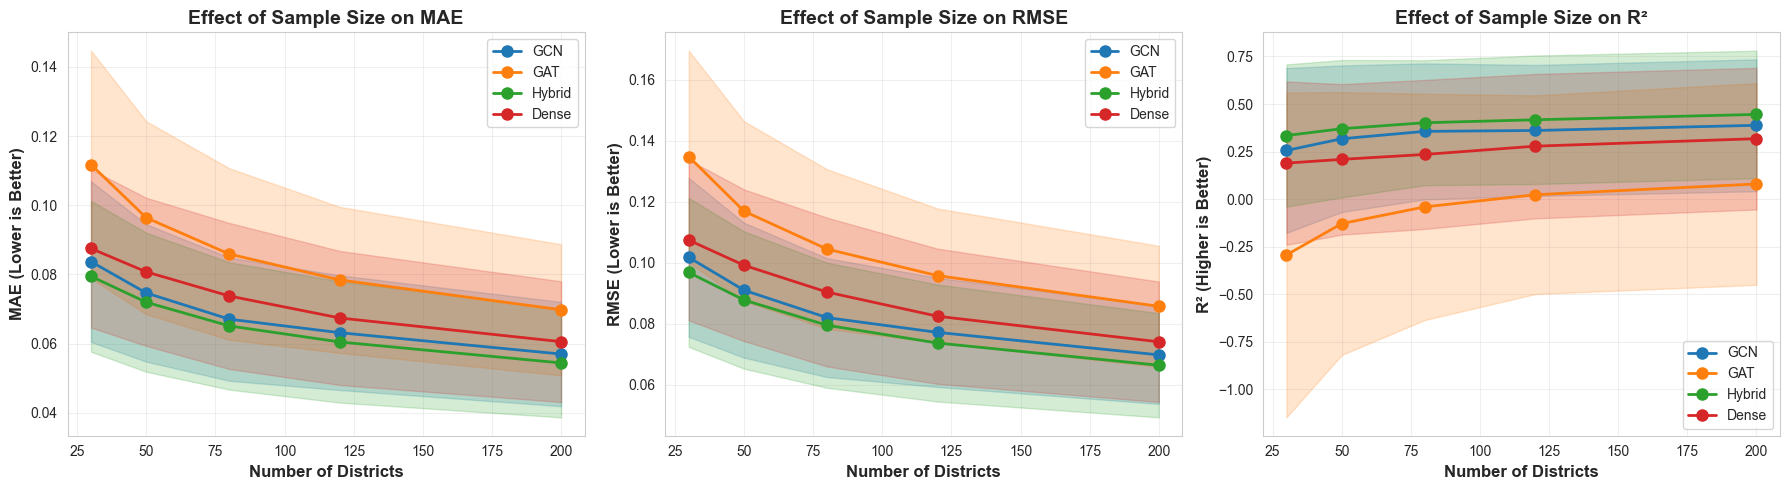

✅ Figure saved: figure_sample_size_effect.png


In [ ]:
# Figure 1: Sample size effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['GCN', 'GAT', 'Hybrid', 'Dense']
colors = {'GCN': '#1f77b4', 'GAT': '#ff7f0e', 'Hybrid': '#2ca02c', 'Dense': '#d62728'}

# MAE
ax = axes[0]
for model in models:
    means = []
    stds = []
    for n_dist in sorted(df_results['n_districts'].unique()):
        df_sub = df_results[df_results['n_districts'] == n_dist]
        means.append(df_sub[f'{model}_mae'].mean())
        stds.append(df_sub[f'{model}_mae'].std())
    
    x = sorted(df_results['n_districts'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Number of Districts', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Sample Size on MAE', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# RMSE
ax = axes[1]
for model in models:
    means = []
    stds = []
    for n_dist in sorted(df_results['n_districts'].unique()):
        df_sub = df_results[df_results['n_districts'] == n_dist]
        means.append(df_sub[f'{model}_rmse'].mean())
        stds.append(df_sub[f'{model}_rmse'].std())
    
    x = sorted(df_results['n_districts'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Number of Districts', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Sample Size on RMSE', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# R²
ax = axes[2]
for model in models:
    means = []
    stds = []
    for n_dist in sorted(df_results['n_districts'].unique()):
        df_sub = df_results[df_results['n_districts'] == n_dist]
        means.append(df_sub[f'{model}_r2'].mean())
        stds.append(df_sub[f'{model}_r2'].std())
    
    x = sorted(df_results['n_districts'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Number of Districts', fontsize=12, fontweight='bold')
ax.set_ylabel('R² (Higher is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Sample Size on R²', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure_sample_size_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figure_sample_size_effect.png")

In [ ]:
# Figure 2: Spatial ρ effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
ax = axes[0]
for model in models:
    means = []
    stds = []
    for rho in sorted(df_results['rho'].unique()):
        df_sub = df_results[df_results['rho'] == rho]
        means.append(df_sub[f'{model}_mae'].mean())
        stds.append(df_sub[f'{model}_mae'].std())
    
    x = sorted(df_results['rho'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Spatial Autocorrelation (ρ)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Spatial ρ on MAE', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# RMSE
ax = axes[1]
for model in models:
    means = []
    stds = []
    for rho in sorted(df_results['rho'].unique()):
        df_sub = df_results[df_results['rho'] == rho]
        means.append(df_sub[f'{model}_rmse'].mean())
        stds.append(df_sub[f'{model}_rmse'].std())
    
    x = sorted(df_results['rho'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Spatial Autocorrelation (ρ)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Spatial ρ on RMSE', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# R²
ax = axes[2]
for model in models:
    means = []
    stds = []
    for rho in sorted(df_results['rho'].unique()):
        df_sub = df_results[df_results['rho'] == rho]
        means.append(df_sub[f'{model}_r2'].mean())
        stds.append(df_sub[f'{model}_r2'].std())
    
    x = sorted(df_results['rho'].unique())
    ax.plot(x, means, 'o-', label=model, color=colors[model], linewidth=2, markersize=8)
    ax.fill_between(x, 
                    np.array(means) - np.array(stds), 
                    np.array(means) + np.array(stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Spatial Autocorrelation (ρ)', fontsize=12, fontweight='bold')
ax.set_ylabel('R² (Higher is Better)', fontsize=12, fontweight='bold')
ax.set_title('Effect of Spatial ρ on R²', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure_spatial_rho_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Figure saved: figure_spatial_rho_effect.png")

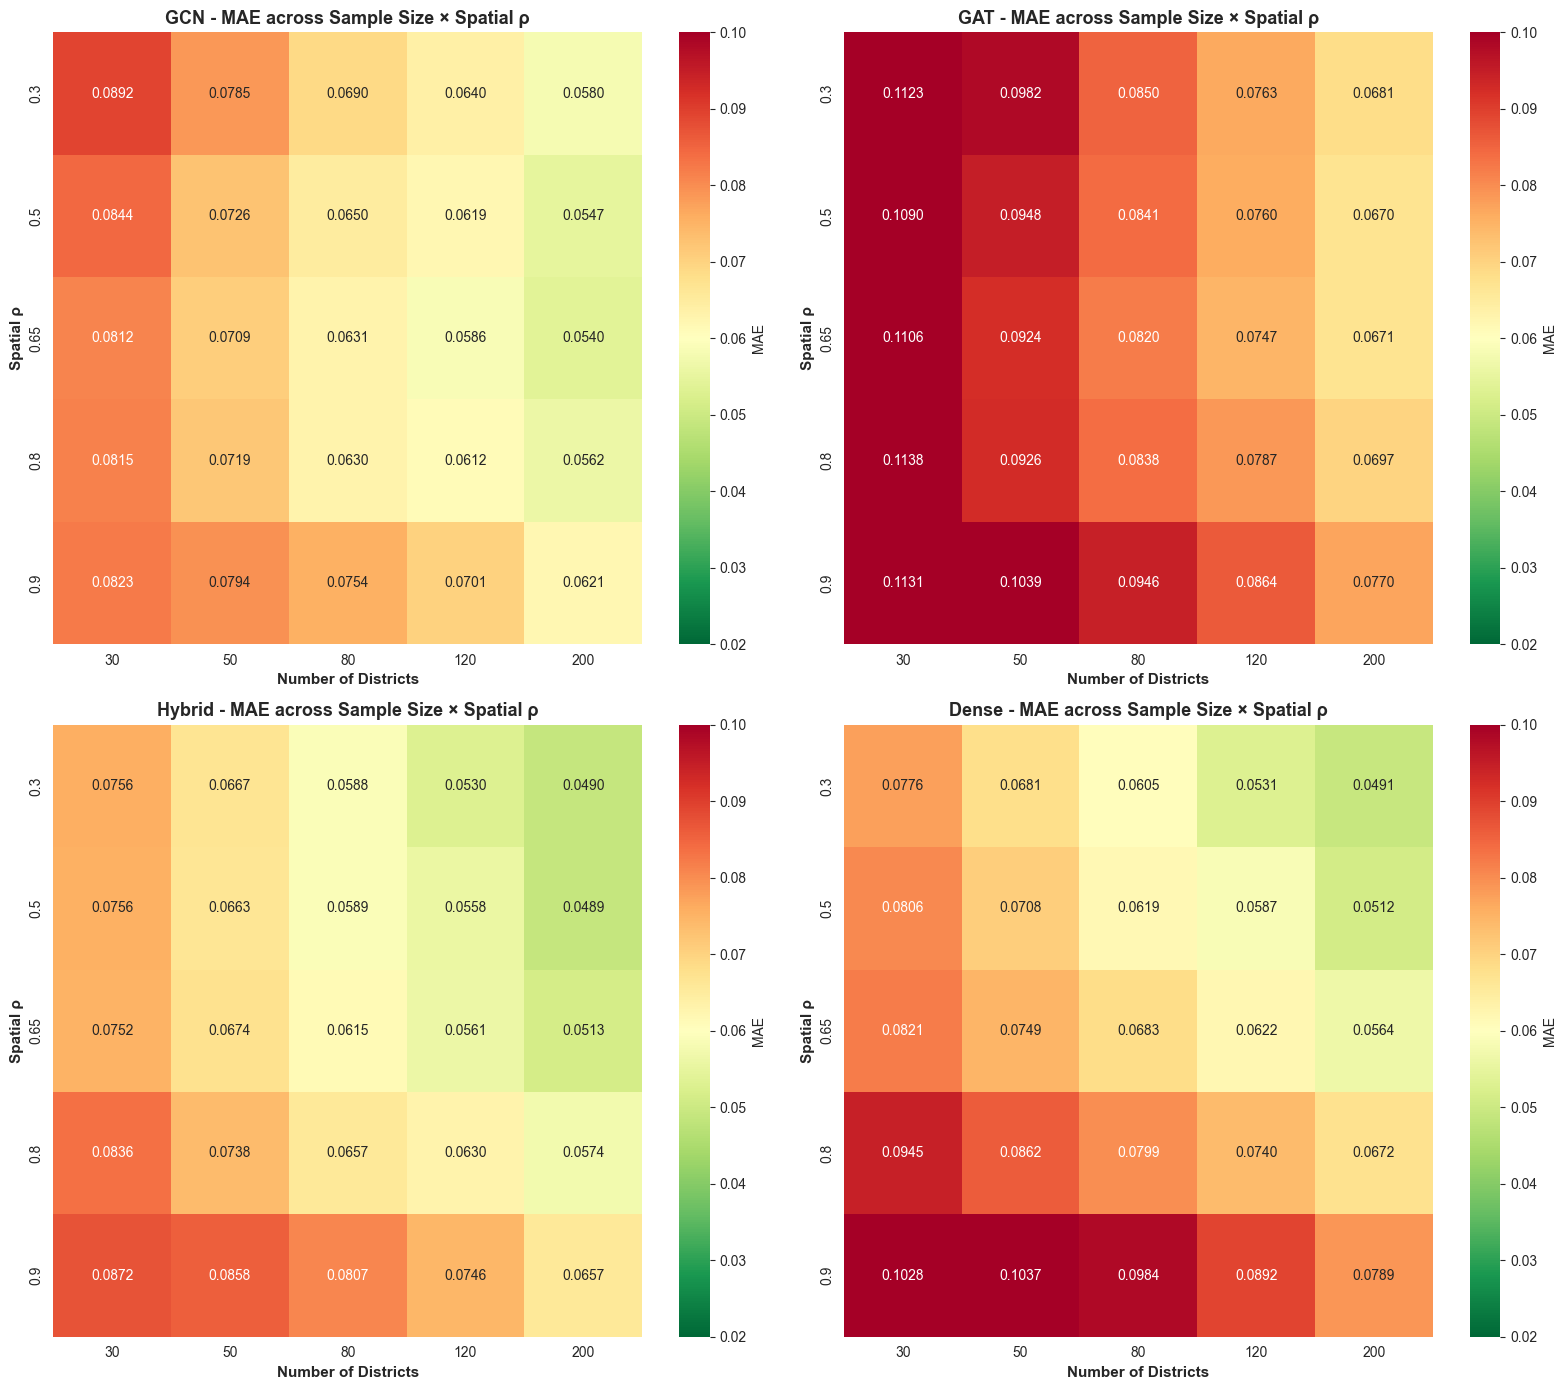

✅ Figure saved: figure_interaction_heatmap.png


In [ ]:
# Figure 3: Heatmap - Interaction between sample size and spatial ρ
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, model in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    
    # Create pivot table
    pivot_data = table_interaction_mae.pivot(index='rho', 
                                             columns='n_districts', 
                                             values=f'{model}_mean')
    
    # Plot heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'MAE'}, ax=ax, vmin=0.02, vmax=0.10)
    
    ax.set_title(f'{model} - MAE across Sample Size × Spatial ρ', 
                fontsize=13, fontweight='bold')
    ax.set_xlabel('Number of Districts', fontsize=11, fontweight='bold')
    ax.set_ylabel('Spatial ρ', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figure_interaction_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Figure saved: figure_interaction_heatmap.png")